# Test simulation matching

## Imports

In [1]:
import sys
import os
import pprint
import cPickle as pickle
import numpy as np
from matplotlib import pyplot as plt
gleam_root = "/Users/phdenzel/gleam"
sys.path.append(gleam_root)
from gleam.utils.lensing import LensModel
from gleam.lensobject import LensObject
from gleam.reconsrc import ReconSrc
from gleam.utils.plotting import IPColorbar, IPPointCache
from gleam.utils.plotting import plot_scalebar, plot_labelbox
import gleam.utils.colors as gcl
gcl.GLEAMcmaps.register_all()
# from gleam.glass_interface import glass_renv
# glass = glass_renv()

## Load lensing data and models

In [2]:
ids = ['SDSSJ0029-0055', 'SDSSJ0737+3216', 'SDSSJ0753+3416', 'SDSSJ0956+5100',
       'SDSSJ1051+4439', 'SDSSJ1430+6104', 'SDSSJ1627-0053']
jsons = !ls data/*.json
obs = {k:v for k, v in zip(ids, jsons)}
pkls = !ls models/*.pkl
mdls = {k:v for k, v in zip(ids, pkls)}
pprint.pprint(obs)
print
pprint.pprint(mdls)

{'SDSSJ0029-0055': 'data/SDSSJ0029-0055.json',
 'SDSSJ0737+3216': 'data/SDSSJ0737+3216.json',
 'SDSSJ0753+3416': 'data/SDSSJ0753+3416.json',
 'SDSSJ0956+5100': 'data/SDSSJ0956+5100.json',
 'SDSSJ1051+4439': 'data/SDSSJ1051+4439.json',
 'SDSSJ1430+6104': 'data/SDSSJ1430+6104.json',
 'SDSSJ1627-0053': 'data/SDSSJ1627-0053.json'}

{'SDSSJ0029-0055': 'models/SDSSJ0029-0055_kappa_re0.97_zl0.23zs0.93.pkl',
 'SDSSJ0737+3216': 'models/SDSSJ0737+3216_kappa_re1.03_zl0.32zs0.58.pkl',
 'SDSSJ0753+3416': 'models/SDSSJ0753+3416_kappa_re1.31_zl0.14zs0.96.pkl',
 'SDSSJ0956+5100': 'models/SDSSJ0956+5100_kappa_re1.40_zl0.24zs0.47.pkl',
 'SDSSJ1051+4439': 'models/SDSSJ1051+4439_kappa_re1.50_zl0.16zs0.54.pkl',
 'SDSSJ1430+6104': 'models/SDSSJ1430+6104_kappa_re1.15_zl0.17zs0.65.pkl',
 'SDSSJ1627-0053': 'models/SDSSJ1627-0053_kappa_re1.27_zl0.21zs0.52.pkl'}


In [3]:
objects = []
for k in ids:
    with open(obs[k]) as f:
        l = LensObject.from_json(f)
        objects.append(l)
pprint.pprint(objects)

[LensObject(@[7.2824, -0.9308]),
 LensObject(@[114.3846, 32.2833]),
 LensObject(@[118.4425, 34.2758]),
 LensObject(@[149.1444, 51.0112]),
 LensObject(@[162.7892, 44.6525]),
 LensObject(@[217.6450, 61.0680]),
 LensObject(@[246.9573, -0.8845])]


<IPython.core.display.Javascript object>


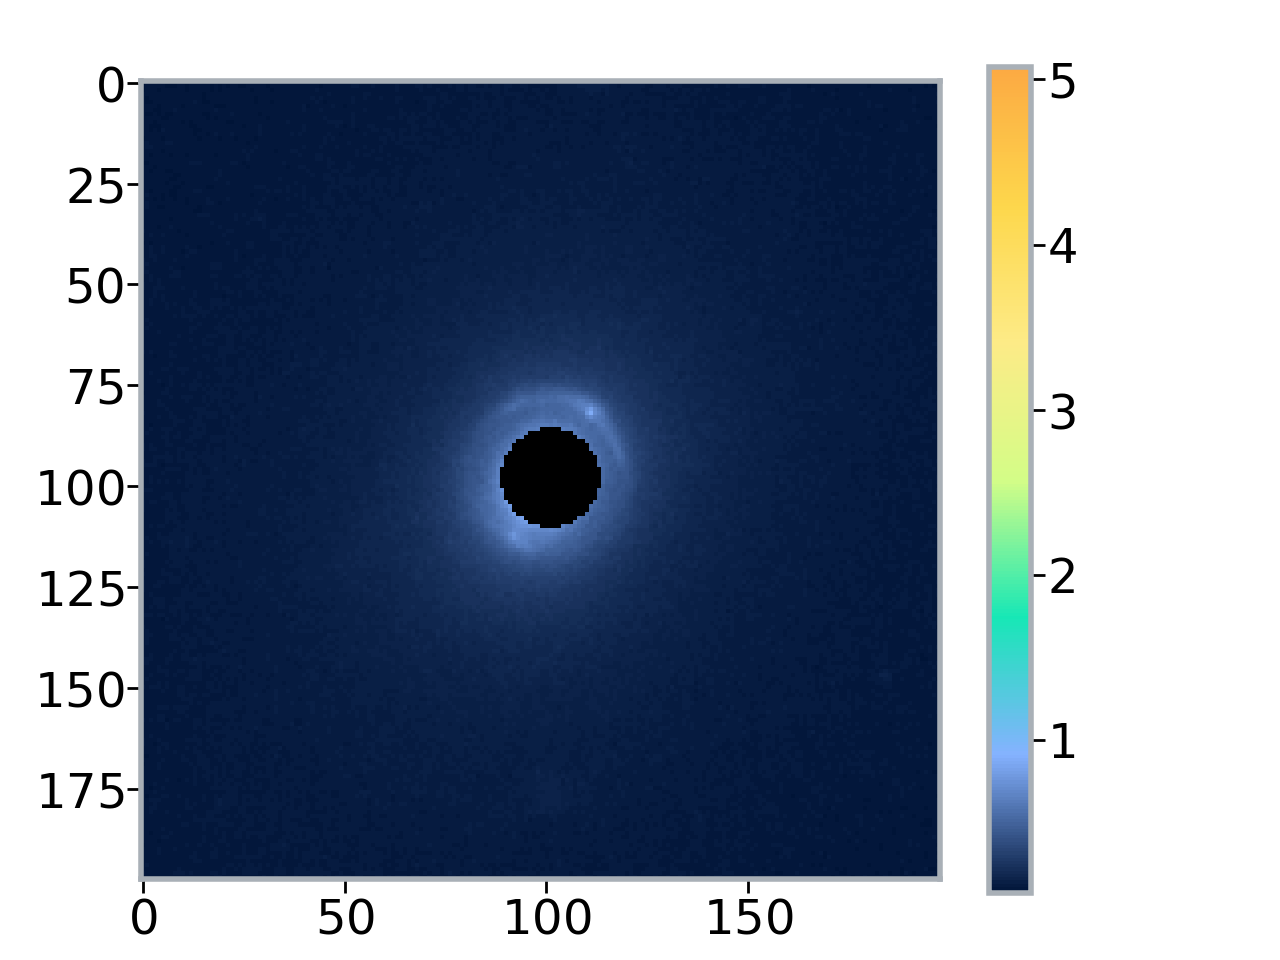

SEJveChjaGlsZHJlbj0oRHJvcGRvd24oZGVzY3JpcHRpb249dSdDb2xvcm1hcCcsIGluZGV4PTE4NiwgbGF5b3V0PUxheW91dCh3aWR0aD11JzEwMCUnKSwgb3B0aW9ucz0odSdBY2NlbnQnLCDigKY=


In [13]:
%matplotlib notebook

lo = objects[0]

fig, ax = plt.subplots()
plt_out = plt.imshow(lo.data, cmap=gcl.GLEAMcmaps.vilux)
cb = plt.colorbar()

msk = np.zeros(lo.roi.mask.shape + (4,))
msk[:, :, 3] = lo.roi.mask
plt.imshow(msk)

clrbar = IPColorbar(cb, plt_out)
clrbar.connect()

In [5]:
models = []
for k in ids:
    with open(mdls[k]) as f:
        mdl_pars = pickle.load(f)
        mdl_pars[1].pop('filename')
        lm = LensModel(mdl_pars[0], filename=mdls[k], **mdl_pars[1])
        models.append(lm)
# print(models[0].__v__)

### Resample to coarse kappa maps

In [6]:
# plt.imshow(models[0].data[5])
print models[0].data.shape

from scipy import ndimage
d = ndimage.interpolation.zoom(models[0].data, [1, 1./7, 1./7], order=0)
# plt.imshow(d[0])
print d.shape

(697, 161, 161)
(697, 23, 23)


In [7]:
from scipy import ndimage
new_pixrad = 11

rescaled_models = []
for k, lm in zip(ids, models):
    kw = {}
    kw['pixrad'] = new_pixrad
    kw['maprad'] = lm.maprad
    zoom_factor = (2*new_pixrad + 1.)/(2*lm.pixrad + 1)
    data = ndimage.interpolation.zoom(lm.data, [1, zoom_factor, zoom_factor], order=0)
    lm_resc = LensModel(data, filename="{}_kappa@pixrad{}".format(k, new_pixrad), **kw)
    rescaled_models.append(lm_resc)

In [8]:
print rescaled_models[0].__v__

filename            	SDSSJ0029-0055_kappa@pixrad11
filepath            	SDSSJ0029-0055_kappa@pixrad11
N                   	697
pixrad              	11
maprad              	4.0
pixel_size          	0.347826086957
kappa               	None
minima              	[]
saddle_points       	[]
maxima              	[]


### Inspect source reconstruction and synthetics

In [9]:
lo = objects[0]
lm = rescaled_models[0]

reconsrc = ReconSrc(lo, lm, M=80, M_fullres=320, mask_keys=['circle'])


print '#'*3, 'LensModel'
print lm.__v__
print
print '#'*3, 'LensObject'
print lo.__v__

### LensModel
filename            	SDSSJ0029-0055_kappa@pixrad11
filepath            	SDSSJ0029-0055_kappa@pixrad11
N                   	697
pixrad              	11
maprad              	4.0
pixel_size          	0.347826086957
kappa               	None
minima              	[]
saddle_points       	[]
maxima              	[]

### LensObject
Properties of that field are unknown [None]
filename            	SDSSJ0029-0055.json
filepath            	/Users/phdenzel/slacs-match/data/SDSSJ0029-0055.json
band                	
naxis1              	198
naxis2              	198
naxis_plus          	None
refval              	[7.2962736899742, -0.92610179418719]
refpx               	[-899.50000000016, 434.99999999984]
center              	<7.2824, -0.9308>
px2deg              	[1.3888888888888002e-05, 1.38888888888896e-05]
px2arcsec           	[0.049999999999996804, 0.050000000000002556]
megacam_range       	None
field               	None
photzp              	None
mag_formula         	<function mag_fo

<IPython.core.display.Javascript object>


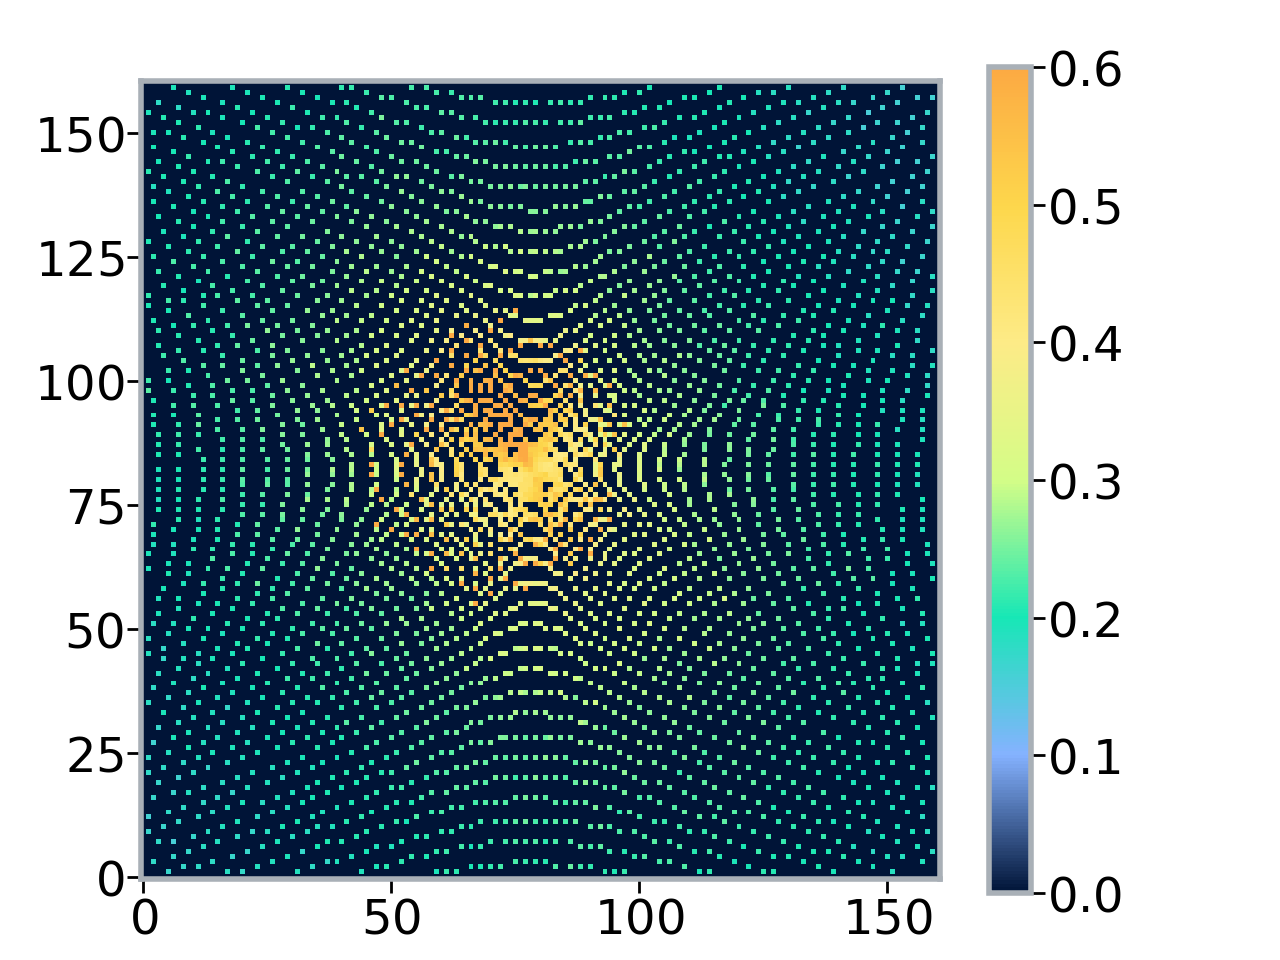

SEJveChjaGlsZHJlbj0oRHJvcGRvd24oZGVzY3JpcHRpb249dSdDb2xvcm1hcCcsIGluZGV4PTE4NiwgbGF5b3V0PUxheW91dCh3aWR0aD11JzEwMCUnKSwgb3B0aW9ucz0odSdBY2NlbnQnLCDigKY=


In [14]:
%matplotlib notebook
srcmap = reconsrc.plane_map(method='minres', use_psf=False, use_mask=True)

fig, ax = plt.subplots()
plt_out = plt.imshow(srcmap, origin='lower', cmap=gcl.GLEAMcmaps.vilux)
cb = plt.colorbar()

clrbar = IPColorbar(cb, plt_out)
clrbar.connect()

<IPython.core.display.Javascript object>


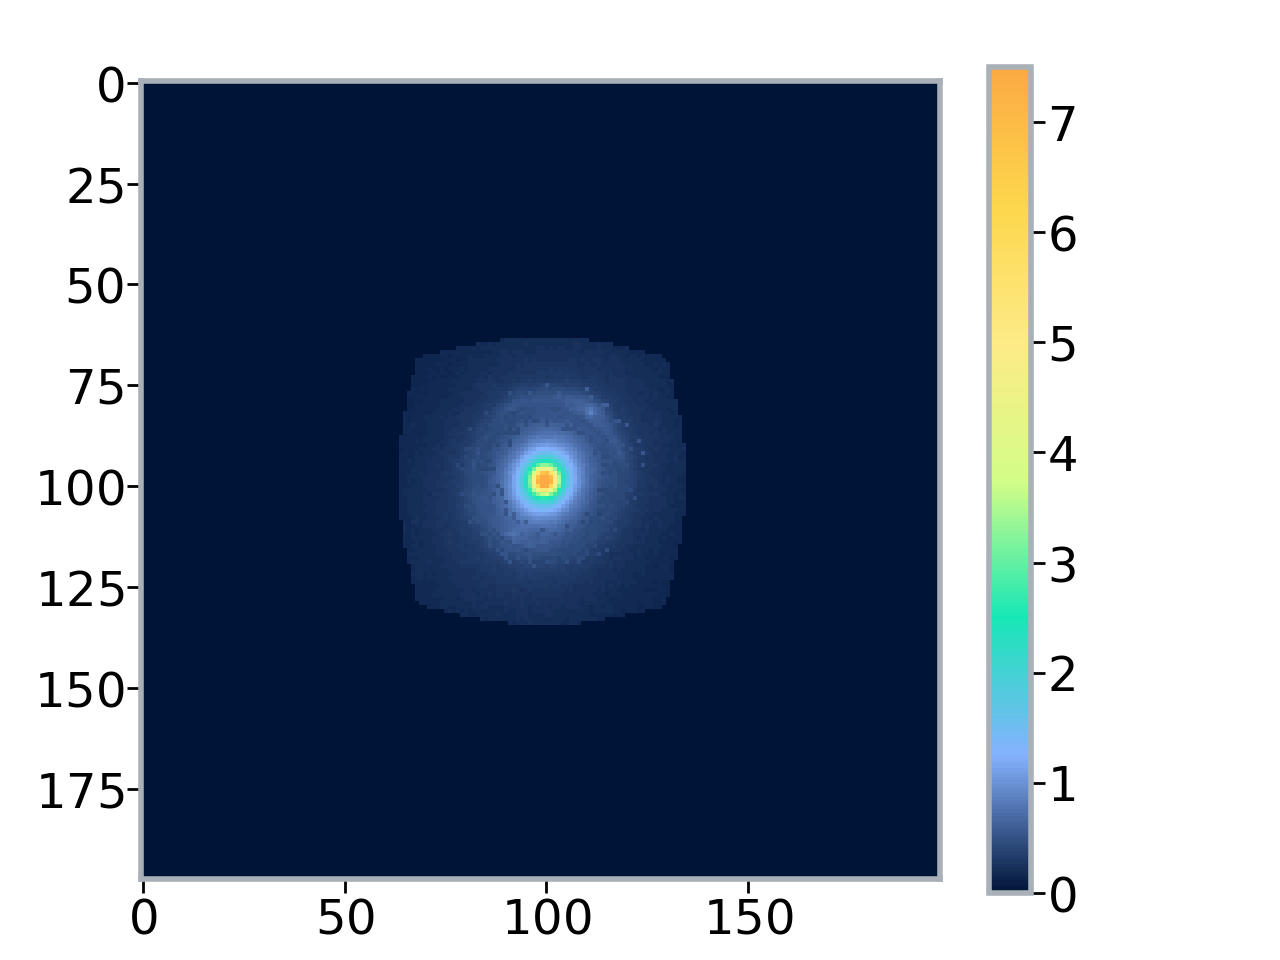

SEJveChjaGlsZHJlbj0oRHJvcGRvd24oZGVzY3JpcHRpb249dSdDb2xvcm1hcCcsIGluZGV4PTE4NiwgbGF5b3V0PUxheW91dCh3aWR0aD11JzEwMCUnKSwgb3B0aW9ucz0odSdBY2NlbnQnLCDigKY=


In [15]:
%matplotlib notebook
synth = reconsrc.reproj_map(method='minres', use_psf=False, use_mask=True)

fig, ax = plt.subplots()
plt_out = plt.imshow(synth, cmap=gcl.GLEAMcmaps.vilux)
cb = plt.colorbar()

# msk = np.zeros(reconsrc.mask.shape + (4,))
# msk[:, :, 3] = reconsrc.mask
# plt.imshow(msk)

# msk = np.zeros(reconsrc.image_mask().shape + (4,))
# msk[:, :, 3] = reconsrc.image_mask()
# plt.imshow(msk)

clrbar = IPColorbar(cb, plt_out)
clrbar.connect()

<IPython.core.display.Javascript object>


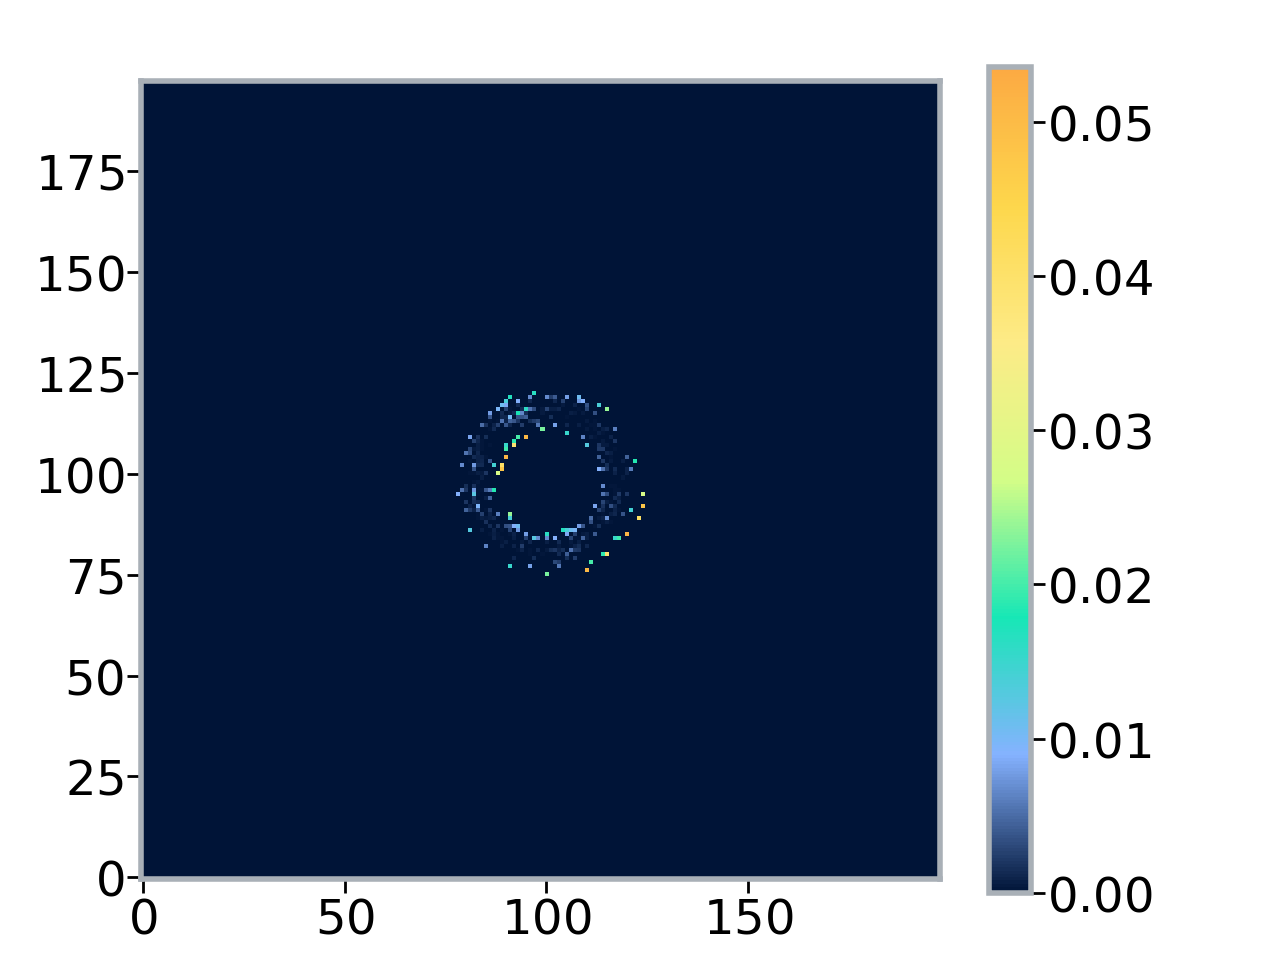

SEJveChjaGlsZHJlbj0oRHJvcGRvd24oZGVzY3JpcHRpb249dSdDb2xvcm1hcCcsIGluZGV4PTE4NiwgbGF5b3V0PUxheW91dCh3aWR0aD11JzEwMCUnKSwgb3B0aW9ucz0odSdBY2NlbnQnLCDigKY=


In [16]:
%matplotlib notebook
synth = reconsrc.residual_map(method='minres', use_psf=False, use_mask=True, nonzero_only=True)

fig, ax = plt.subplots()
plt_out = plt.imshow(synth, origin='lower', cmap=gcl.GLEAMcmaps.vilux)
cb = plt.colorbar()

# msk = np.zeros(reconsrc.mask.shape + (4,))
# msk[:, :, 3] = reconsrc.mask
# plt.imshow(msk)

clrbar = IPColorbar(cb, plt_out)
clrbar.connect()